# [실습] 다양한 Graph 구조

그동안 배운 요소들을 바탕으로, 이번에는 기존의 Graph 구조를 보다 확장시켜 보겠습니다.   

간단한 Router 구조,

하나의 출발점에서 여러 개로 분리되는 Parallel Calling 이후에 결과를 합치는 Map Reduce 방식,

생성자와 평가자의 구조를 반복하는 Evaluator-Optimizer 방식을 구현해 보겠습니다.



In [ ]:
!pip install langgraph langchain langchain_google_genai langchain_community

In [1]:
import os
os.environ['GOOGLE_API_KEY'] = 'AIxxx'

from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_google_genai import ChatGoogleGenerativeAI

# Gemini API는 분당 10개 요청으로 제한
# 즉, 초당 약 0.167개 요청 (10/60)
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.167,  # 분당 10개 요청
    check_every_n_seconds=0.1,  # 100ms마다 체크
    max_bucket_size=10,  # 최대 버스트 크기
)

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    rate_limiter=rate_limiter,
    # temperature
    # max_tokens

    thinking_budget = 500  # 추론(Reasoning) 토큰 길이 제한
)

## 1. Router
라우터는 State의 값을 참고하여, 목적에 따라 서로 다른 노드로 전달하는 방식을 의미합니다.   
주로 사용자의 입력을 분류하여 서로 다른 작업을 연결하는 의도 분류(Intent Classfication)에서 활용됩니다.

In [2]:
from typing_extensions import TypedDict, Annotated, Literal, List
from pydantic import BaseModel, Field
from langgraph.graph.message import add_messages

class Recipe(BaseModel):
    name: str = Field(..., description="음식 이름")
    difficulty: str = Field(..., description="만들기의 난이도")
    origin: str = Field(..., description="원산지")
    ingredients: List[str] = Field(..., description="재료 목록")
    instructions: List[str] = Field(..., description="조리법")
    taste: List[str] = Field(..., description="맛에 대한 한 마디의 묘사!")

class Movie(BaseModel):
    name: str = Field(..., description="영화 이름")
    director: str = Field(..., description="감독명")
    actor: List[str] = Field(..., description="주연 배우: 최대 3명까지")
    recommendation: str = Field(..., description="추천하는 이유!")


class State(TypedDict):
    query: str
    classification: str
    recipe: Recipe
    movie:Movie
    advice : Literal['네!', '아니오.']
    # Literal: 범위가 특정 값으로 한정되는 경우
    answer: str



In [3]:
from langchain_core.prompts import ChatPromptTemplate
import random

def recommend_recipe(state):
    prompt = ChatPromptTemplate([
    ('system','당신은 전세계의 이색적인 퓨전 조리법의 전문가입니다.'),
    ('user','''{query}''')
    ])

    recipe_chain = prompt | llm.with_structured_output(Recipe)

    return {'recipe':recipe_chain.invoke(state)}
    # query --> query

def recommend_movie(state):
    prompt = ChatPromptTemplate([
    ('system','당신은 고전 영화의 전문가입니다.'),
    ('user','''{query}''')
    ])

    movie_chain = prompt | llm.with_structured_output(Movie)

    return {'movie':movie_chain.invoke(state)}
    # query --> query


def talk(state):
    return {'answer':llm.invoke(state['query']).content}


def counsel(state):
    if random.random()>=0.5:
        return {'advice':'네!'}
    else:
        return {'advice':'아니오.'}



In [4]:
def route(state):

    prompt = ChatPromptTemplate(
        [('system', '''당신의 역할은 사용자의 질문에 대답할 사람을 선택하는 것입니다.
1) 음식 관련 질문: 'FOOD'만 출력하세요.
2) 영화 관련 질문: 'MOVIE'만 출력하세요.
3) 고민 상담: 'COUNSEL'만 출력하세요.
4) 그 외의 대화: 'TALK'만 출력하세요.
             '''),
             ('user','User Query: {query}')
        ]
    )
    # Structured_Output으로 만들 수도 있습니다!

    route_chain = prompt | llm

    return {"classification": route_chain.invoke(state).content}
    # query --> query


def route_decision(state):
    # Exact Match 대신 조금 안정적인 조건식

    if "FOOD" in state["classification"]:
        return "recommend_recipe"
    elif "MOVIE" in state["classification"]:
        return "recommend_movie"
    elif "TALK" in state["classification"]:
        return "talk"
    else:
        return "counsel"

In [5]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)

builder.add_node('recommend_movie', recommend_movie)
builder.add_node('recommend_recipe', recommend_recipe)
builder.add_node('counsel', counsel)
builder.add_node('talk', talk)
builder.add_node('route', route)

builder.add_edge(START, 'route')
builder.add_conditional_edges('route', route_decision,
                              {'recommend_movie':'recommend_movie',
                               'recommend_recipe':'recommend_recipe',
                               'counsel':'counsel',
                               'talk':'talk'})

builder.add_edge('recommend_movie', END)
builder.add_edge('recommend_recipe', END)
builder.add_edge('counsel', END)
builder.add_edge('talk', END)


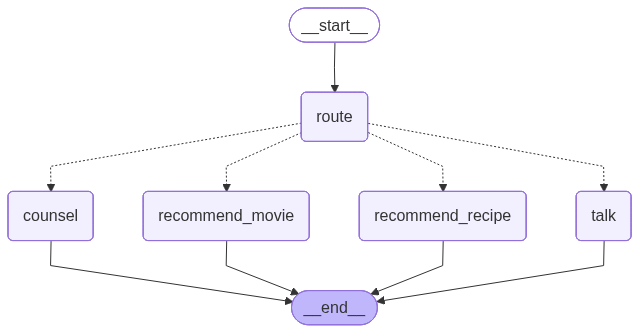

In [6]:
graph = builder.compile()
graph

In [7]:
query = '2월에 어울리는 한국영화 추천해줘.'

result = graph.invoke({'query':query})
result

{'query': '2월에 어울리는 한국영화 추천해줘.',
 'classification': 'MOVIE',
 'movie': Movie(name='엽기적인 그녀', director='곽재용', actor=['전지현', '차태현'], recommendation='2월에 따뜻하고 유쾌한 로맨틱 코미디를 즐기기에 완벽한 영화입니다. 사랑과 운명, 그리고 성장에 대한 이야기를 유머러스하면서도 감동적으로 풀어내어 시간이 지나도 변치 않는 감동을 선사합니다.')}

In [8]:
query = '연두부로 만들 수 있는 파인 다이닝 메뉴 추천해주세요'

result = graph.invoke({'query':query})
result

{'query': '연두부로 만들 수 있는 파인 다이닝 메뉴 추천해주세요',
 'classification': 'FOOD',
 'recipe': Recipe(name='연두부 캐비어 타르타르와 유자 폰즈 젤리', difficulty='중상', origin='한일 퓨전', ingredients=['연두부 1팩', '아보카도 1/2개', '칵테일 새우 50g', '날치알 2큰술', '유자 폰즈 소스 3큰술', '간장 1큰술', '참기름 1/2큰술', '다진 쪽파 1큰술', '구운 김 가루 약간', '식용 꽃 약간 (장식용)', '한천 가루 1/2작은술 (유자 폰즈 젤리용)', '물 50ml (유자 폰즈 젤리용)'], instructions=['1. 연두부는 면포에 싸서 물기를 최대한 제거한 후 부드럽게 으깨어 준비합니다.', '2. 아보카도는 작은 주사위 모양으로 썰고, 칵테일 새우는 잘게 다져줍니다.', '3. 으깬 연두부에 간장, 참기름, 다진 쪽파를 넣고 잘 섞어줍니다. (기호에 따라 소금으로 간을 추가할 수 있습니다.)', '4. 작은 냄비에 물과 한천 가루를 넣고 잘 저어가며 끓여 한천을 녹입니다. 불을 끄고 유자 폰즈 소스를 넣어 섞은 후, 납작한 용기에 부어 냉장고에서 1시간 이상 굳혀 유자 폰즈 젤리를 만듭니다. 젤리가 굳으면 잘게 다지거나 큐브 모양으로 썰어줍니다.', '5. 원형 틀을 이용해 접시 중앙에 연두부 타르타르를 올리고, 그 위에 다진 아보카도와 칵테일 새우를 층층이 올립니다.', '6. 가장 위에 날치알을 풍성하게 올리고, 주변에 준비한 유자 폰즈 젤리를 보기 좋게 배치합니다.', '7. 구운 김 가루와 식용 꽃으로 장식하여 마무리합니다.'], taste=['부드러운 연두부의 고소함과 상큼한 유자 폰즈 젤리, 톡톡 터지는 날치알의 조화가 일품인 섬세한 맛'])}

In [9]:
query = 'MoE 구조에 대해 5문장으로 설명해주세요.'

result = graph.invoke({'query':query})
result

{'query': 'MoE 구조에 대해 5문장으로 설명해주세요.',
 'classification': 'TALK',
 'answer': "Mixture of Experts (MoE)는 여러 개의 작은 신경망, 즉 '전문가(experts)'를 활용하는 딥러닝 아키텍처입니다. 입력 데이터가 들어오면 '게이팅 네트워크(gating network)' 또는 '라우터(router)'가 해당 입력에 가장 적합한 전문가를 동적으로 선택합니다. 선택된 전문가만 활성화되어 계산을 수행하며, 각 전문가는 특정 종류의 데이터나 작업에 특화되어 훈련됩니다. 이 구조는 모델의 전체 파라미터 수는 크게 늘리면서도 실제 계산 시에는 일부만 활성화되므로, 효율적으로 모델 용량을 확장하고 복잡한 작업을 처리할 수 있게 해줍니다. 결과적으로, MoE는 대규모 언어 모델 등에서 모델의 성능을 향상시키면서도 추론 비용을 관리하는 데 효과적인 방법으로 활용됩니다."}

## 2. Map-Reduce

위에서는 분류 후에 1번의 LLM을 호출했는데요.   
각자 실행하고 합치는 구조도 만들 수 있습니다.   

대표적인 작업인 리포트 작성 구조를 보겠습니다.   
최초의 LLM이 주제에 대한 섹션을 먼저 구성하고, 섹션별 리포트를 각각의 LLM이 작성하는 방식입니다.

In [10]:
# 전체 섹션의 구획: Contents (Chapter List)
# Chapter: name, outline
class Chapter(BaseModel):
    name: str = Field(description="챕터의 이름")
    outline: str = Field(description="챕터의 주요 내용, 1문장 길이로")


class Contents(BaseModel):
    contents: List[Chapter] = Field(description="전체 리포트의 섹션 구성")


planner = llm.with_structured_output(Contents)

In [11]:
example = planner.invoke("LLM의 발전 과정에 대한 보고서 구획을 작성해 주세요.")
example.contents

[Chapter(name='서론: LLM의 정의와 중요성', outline='거대 언어 모델(LLM)이 무엇인지 정의하고, 현대 AI 및 다양한 산업 분야에서 LLM이 가지는 중요성을 소개합니다.'),
 Chapter(name='초기 자연어 처리 모델의 발전', outline='트랜스포머 등장 이전의 주요 NLP 모델들(통계 기반 모델, RNN, LSTM 등)과 그 한계를 설명합니다.'),
 Chapter(name='트랜스포머 아키텍처의 등장과 혁신', outline='어텐션 메커니즘을 기반으로 한 트랜스포머 아키텍처가 어떻게 기존 모델의 한계를 극복하고 LLM 발전의 기틀을 마련했는지 다룹니다.'),
 Chapter(name='거대 언어 모델의 스케일링과 능력', outline='모델 크기 증가(스케일링)가 LLM의 성능과 새로운 능력(Emergent Abilities) 발현에 미친 영향을 분석합니다.'),
 Chapter(name='파인튜닝 및 명령어 추종 능력의 발전', outline='사전 학습된 LLM을 특정 작업에 맞게 조정하는 파인튜닝(Fine-tuning)과 사용자 명령을 더 잘 이해하고 따르게 하는 기술(RLHF 등)의 발전을 설명합니다.'),
 Chapter(name='최신 LLM 동향 및 응용 분야', outline='현재 주목받는 주요 LLM(GPT 시리즈, PaLM, LLaMA 등)과 이들이 적용되고 있는 다양한 산업 및 서비스 분야를 소개합니다.'),
 Chapter(name='LLM 발전의 도전 과제와 미래 전망', outline='LLM이 직면한 윤리적 문제, 편향성, 환각 현상 등의 도전 과제를 논의하고, 향후 LLM 연구 및 발전 방향에 대해 전망합니다.')]

그래프에서 사용할 State를 정의합니다.   

이번에는 중간 Writer LLM이 사용할 State를 별도로 만들어 보겠습니다.   
이렇게 구성하면 최종 State에서 필요한 부분만 저장할 수 있습니다.

In [12]:
import operator

# reducer 구조: operator.add
# 단순 + 연산 구조 (리스트의 + 연산이므로 append)

class State(TypedDict):
    topic: str
    contents: list[Chapter]
    completed_sections: Annotated[list, operator.add]
    final_report: str


# 섹션 Writer가 사용할 State
class SubState(TypedDict):
    chapter: Chapter
    completed_sections: Annotated[list, operator.add]



섹션을 생성하는 노드를 구성합니다.

In [13]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

def orchestrator(state: State):

    prompt = ChatPromptTemplate([
        ('system', "주제에 대한 전문가 수준의 깊이 있는 한국어 보고서를 쓰려고 합니다. 보고서의 섹션 구성과, 각 섹션의 간단한 설명을 작성해 주세요."),
        ('user', "주제: {topic}")
    ])
    chain = prompt | planner

    # chain 결과물: Contents (contents: List[Chapter])

    return {"contents": chain.invoke(state).contents}
    # state: topic --> topic
    # Return: List[Chapter]



섹션별 내용을 처리하는 노드를 구성합니다.   
State에는 각각의 Chapter가 아닌 Chapter의 리스트인 Contents가 들어 있는데요.   

`SubState`를 이용해, 각각의 Chapter를 처리하도록 정의하겠습니다.

In [14]:
def llm_call(state: SubState):
    # SubState :  chapter, completed_sections 2개 property

    chapter = state['chapter']

    prompt = ChatPromptTemplate([
        ('system',"아래 섹션에 대한 상세한 한국어 보고서를 작성하세요." ),
        ('user', "섹션 이름과 주제는 다음과 같습니다: {name} --> {outline}")
    ])

    chain = prompt | llm

    return {"completed_sections": [chain.invoke({'name':chapter.name, 'outline':chapter.outline}).content]}
    # 리스트로 Wrap하는 이유 중요(Reduce Operator 합치기 위해서)


# 생성된 섹션별 결과들을 결합
def synthesizer(state: State):

    completed_sections = state["completed_sections"]

    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    # join: 전체 리스트 스트링으로 결합하기

    return {"final_report": completed_report_sections}




**가장 중요한 부분입니다😁😁**   
langgraph의 Send()를 이용하면, 리스트의 원소 개수만큼 서브모듈을 호출할 수 있습니다.

In [ ]:
from langgraph.types import Send

def assign_workers(state: State):
    # Send: 노드를 호출하며, 값을 전달해 준다
    # state['contents']의 개수를 기본적으로 알 수 없는데,
    # 이를 통해 개수만큼 llm_call을 생성하여 호출할 수 있음

    return [Send("llm_call", {"chapter": s}) for s in state["contents"]]

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18068\3438576989.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


그래프를 구성합니다.

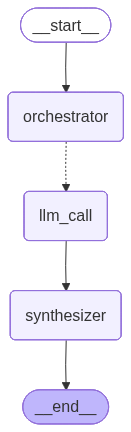

In [16]:
builder = StateGraph(State)

builder.add_node("orchestrator", orchestrator) # 구획 짜고
builder.add_node("llm_call", llm_call) # 섹션별 글쓰고
builder.add_node("synthesizer", synthesizer) # 합치고


builder.add_edge(START, "orchestrator")

builder.add_conditional_edges("orchestrator", assign_workers, ["llm_call"])
# assign_workers의 결과에 따라 llm_call을 호출

builder.add_edge("llm_call", "synthesizer")
# 생성된 섹션들은 synthesizer로 이동

builder.add_edge("synthesizer", END) # 끝


graph = builder.compile()
graph

In [17]:
for data in graph.stream({"topic": "GPT 1부터 최신 LLM까지의 발전과정"}, stream_mode='updates'):
    print(data)
    print('--------------')
    # 생성은 병렬적이지만 합치는 순서는 호출한 순서

{'orchestrator': {'contents': [Chapter(name='서론', outline='GPT-1부터 최신 LLM까지의 발전 과정을 개괄하고 보고서의 목적을 설명합니다.'), Chapter(name='초기 Transformer 기반 모델의 등장: GPT-1', outline='Transformer 아키텍처를 기반으로 한 최초의 GPT 모델인 GPT-1의 탄생 배경, 주요 특징 및 한계를 다룹니다.'), Chapter(name='성능 향상과 스케일업의 시작: GPT-2', outline='GPT-1의 한계를 극복하고 더 많은 데이터와 파라미터로 학습하여 뛰어난 텍스트 생성 능력을 보여준 GPT-2의 발전 과정을 분석합니다.'), Chapter(name='범용성과 거대 모델의 시대 개막: GPT-3', outline='제로샷 및 퓨샷 학습 능력을 통해 다양한 태스크에 범용적으로 활용 가능하며, 거대 언어 모델 시대를 본격적으로 연 GPT-3의 혁신을 설명합니다.'), Chapter(name='멀티모달리티와 추론 능력의 발전: GPT-4 및 이후 모델', outline='텍스트를 넘어 이미지, 오디오 등 멀티모달 정보를 처리하고 더욱 강화된 추론 능력과 안정성을 보여주는 GPT-4 및 최신 LLM들의 특징을 조명합니다.'), Chapter(name='LLM 발전의 주요 기술적 이정표', outline='전이 학습, 자기 지도 학습, 스케일링 법칙, 인컨텍스트 학습 등 LLM 발전에 기여한 핵심 기술적 발전들을 정리합니다.'), Chapter(name='LLM이 사회에 미친 영향 및 미래 전망', outline='LLM이 산업, 교육, 연구 등 사회 전반에 미친 영향과 함께 윤리적 문제, 한계점, 그리고 앞으로의 발전 방향과 잠재적 응용 분야를 논의합니다.'), Chapter(name='결론', outline='보고서의 주요 내용을 요약하고, LLM의 지속적인 발전이 가져올 미래에 대한 최종적인 견해를 제시합니다.')]}}
--------------

In [18]:
from IPython.display import Markdown
Markdown(data['synthesizer']["final_report"])

## 서론

### GPT-1부터 최신 LLM까지의 발전 과정 개괄

지난 몇 년간 인공지능 분야, 특히 대규모 언어 모델(Large Language Models, LLMs)은 눈부신 발전을 거듭하며 우리 사회와 기술 환경에 혁명적인 변화를 가져왔습니다. 이러한 발전의 시작점 중 하나는 2018년 OpenAI가 발표한 **GPT-1 (Generative Pre-trained Transformer 1)**이었습니다. GPT-1은 트랜스포머(Transformer) 아키텍처의 디코더 부분만을 활용하여 대규모 텍스트 코퍼스에서 비지도 학습 방식으로 사전 학습된 후, 특정 다운스트림 작업에 대해 지도 학습 방식으로 미세 조정되는 '생성적 사전 학습(Generative Pre-training)'이라는 새로운 패러다임을 제시했습니다. 이는 언어 이해와 생성 능력에서 기존 모델들을 뛰어넘는 가능성을 보여주었습니다.

GPT-1의 성공은 모델의 크기와 학습 데이터의 양을 늘리는 것이 성능 향상에 결정적인 영향을 미친다는 통찰로 이어졌습니다. 2019년 등장한 **GPT-2**는 GPT-1보다 훨씬 큰 규모(1.5억 개의 매개변수)로 학습되었으며, 특정 작업에 대한 명시적인 미세 조정 없이도 뛰어난 제로샷(zero-shot) 성능을 보여주며 '비지도 다중 작업 학습자(unsupervised multitask learner)'로서의 잠재력을 입증했습니다. 이는 모델이 단순히 텍스트를 생성하는 것을 넘어, 질문 답변, 요약, 번역 등 다양한 언어 작업을 수행할 수 있음을 시사했습니다.

정점은 2020년에 공개된 **GPT-3**에서 찾아볼 수 있습니다. 1,750억 개의 매개변수를 가진 GPT-3는 인류 역사상 가장 큰 언어 모델 중 하나로, 방대한 데이터셋으로 사전 학습되었습니다. GPT-3의 가장 혁신적인 특징은 '인컨텍스트 학습(in-context learning)' 능력입니다. 즉, 몇 가지 예시(few-shot) 또는 심지어 예시 없이(zero-shot) 프롬프트에 제공된 지시사항만으로 복잡한 작업을 수행할 수 있게 되면서, '프롬프트 엔지니어링(prompt engineering)'이라는 새로운 분야를 탄생시켰습니다. 이는 모델을 미세 조정하는 대신, 적절한 질문이나 지시를 통해 원하는 결과를 얻는 방식으로 LLM 활용의 패러다임을 전환시켰습니다.

GPT-3의 등장 이후, LLM은 단순한 언어 생성 도구를 넘어 인간과 유사한 방식으로 추론하고, 창의적인 콘텐츠를 생성하며, 복잡한 문제를 해결하는 데 활용될 수 있는 잠재력을 보여주었습니다. 하지만 동시에 모델의 편향성, 환각(hallucination), 안전성 문제 등 윤리적, 사회적 도전과제도 부각되었습니다.

이러한 문제들을 해결하고 모델의 실용성을 높이기 위해 **InstructGPT**와 같은 모델들이 개발되었습니다. 이는 인간 피드백 기반 강화 학습(Reinforcement Learning from Human Feedback, RLHF) 기법을 도입하여, 모델이 인간의 의도에 더 잘 부합하고, 덜 유해하며, 더 유용한 출력을 생성하도록 정렬(alignment)하는 데 중점을 두었습니다. 이 과정에서 GPT-3.5 시리즈가 탄생하며 사용자 경험을 크게 개선했습니다.

그리고 2023년, **GPT-4**의 등장은 LLM의 발전이 어디까지 가능한지 다시 한번 보여주었습니다. GPT-4는 텍스트뿐만 아니라 이미지를 입력으로 받아들일 수 있는 멀티모달(multimodal) 능력을 갖추었으며, 이전 세대 모델들보다 훨씬 더 정교한 추론 능력과 복잡한 문제 해결 능력을 선보였습니다. 이는 LLM이 단순한 언어 모델을 넘어, 다양한 형태의 데이터를 이해하고 통합적으로 사고할 수 있는 범용 인공지능(General AI)에 한 걸음 더 다가섰음을 의미합니다.

이러한 발전은 OpenAI의 GPT 시리즈에만 국한되지 않습니다. Google의 PaLM, DeepMind의 Chinchilla, Meta의 LLaMA, Anthropic의 Claude 등 수많은 연구 기관과 기업들이 각자의 혁신적인 LLM을 개발하며 경쟁과 협력을 통해 전체 생태계를 빠르게 확장하고 있습니다. 특히 LLaMA와 같은 오픈 소스 모델의 등장은 LLM 연구의 민주화를 촉진하고, 더욱 다양한 응용 분야의 발전을 이끌고 있습니다.

### 보고서의 목적

본 보고서는 GPT-1부터 GPT-4에 이르는 대규모 언어 모델의 핵심적인 발전 과정을 심층적으로 탐구하고, 각 모델의 주요 특징과 기술적 기여를 분석하는 것을 목적으로 합니다. 더 나아가, LLM의 발전이 가져온 주요 기술적, 사회적 함의를 논의하고, 현재 LLM이 직면하고 있는 도전 과제들(예: 윤리적 문제, 편향성, 환각, 에너지 소비 등)을 조명할 것입니다. 궁극적으로, 본 보고서는 독자들이 LLM의 과거, 현재, 그리고 미래에 대한 포괄적인 이해를 돕고, 이 혁신적인 기술이 우리 사회에 미칠 영향에 대한 깊이 있는 통찰을 제공하고자 합니다. 이를 통해 LLM 기술의 책임감 있는 개발과 활용을 위한 논의의 장을 마련하는 데 기여할 것입니다.

---

## 초기 Transformer 기반 모델의 등장: GPT-1

### 1. 서론: Transformer 아키텍처와 NLP의 전환점

자연어 처리(NLP) 분야는 2010년대 중반까지 주로 순환 신경망(RNN) 및 장단기 기억(LSTM) 네트워크에 의존하여 시퀀스 데이터를 처리해왔습니다. 그러나 이러한 모델들은 장거리 의존성 학습의 어려움과 병렬 처리의 한계라는 고질적인 문제를 안고 있었습니다. 이러한 한계를 극복하기 위해 2017년 Google이 발표한 "Attention Is All You Need" 논문은 혁신적인 Transformer 아키텍처를 제안하며 NLP 연구의 패러다임을 완전히 바꾸어 놓았습니다.

Transformer는 RNN의 순환 구조를 제거하고, 어텐션(Attention) 메커니즘만을 사용하여 입력 시퀀스의 모든 부분에 동시에 집중하고 가중치를 부여함으로써 장거리 의존성을 효과적으로 학습할 수 있게 했습니다. 또한, 병렬 처리의 이점을 극대화하여 대규모 데이터셋에 대한 학습 속도를 비약적으로 향상시켰습니다. 이러한 Transformer의 등장은 거대 언어 모델(Large Language Model, LLM) 시대를 여는 결정적인 계기가 되었습니다.

이러한 배경 속에서 OpenAI는 Transformer 아키텍처의 잠재력을 인식하고, 이를 기반으로 한 최초의 Generative Pre-trained Transformer, 즉 GPT-1 모델을 2018년에 공개하며 사전 학습(Pre-training)과 미세 조정(Fine-tuning)이라는 새로운 학습 패러다임을 제시했습니다.

### 2. GPT-1의 탄생 배경

GPT-1은 Transformer의 강력한 시퀀스 처리 능력과 대규모 비지도 학습의 가능성을 결합하여 범용적인 언어 이해 및 생성 모델을 만들고자 하는 비전에서 탄생했습니다. 당시 NLP 모델들은 특정 작업(예: 감성 분석, 질의응답)에 대해 처음부터 학습되거나, 사전 학습된 단어 임베딩(Word Embedding)을 활용하는 수준에 머물러 있었습니다. 이는 각 작업마다 별도의 모델을 구축하고 많은 양의 레이블링된 데이터를 필요로 하는 비효율적인 방식이었습니다.

OpenAI는 이 문제를 해결하기 위해 다음과 같은 아이디어를 적용했습니다:
*   **Transformer 디코더 활용:** Transformer의 인코더-디코더 구조 중, 문맥을 이해하고 다음 단어를 예측하는 데 특화된 디코더 부분만을 활용하여 언어 모델을 구축했습니다.
*   **비지도 사전 학습:** 레이블이 없는 대규모 텍스트 데이터셋(BooksCorpus)을 사용하여 모델이 일반적인 언어 패턴, 문법, 사실적 지식을 학습하도록 했습니다. 이 과정에서 모델은 다음 단어를 예측하는(Next Word Prediction) 언어 모델링(Language Modeling) 작업을 수행했습니다.
*   **지도 미세 조정:** 사전 학습을 통해 얻은 범용적인 언어 지식을 바탕으로, 특정 하류 작업(Downstream Tasks)에 대한 소량의 레이블링된 데이터로 모델을 미세 조정하여 해당 작업에 특화된 성능을 달성하는 방식을 제안했습니다.

이러한 '사전 학습(Pre-training) 후 미세 조정(Fine-tuning)' 패러다임은 당시 NLP 분야에서 혁신적인 접근 방식이었으며, GPT-1은 이 패러다임을 성공적으로 구현한 첫 번째 모델 중 하나였습니다.

### 3. GPT-1의 주요 특징

GPT-1은 다음과 같은 주요 특징을 가집니다.

*   **아키텍처:**
    *   **Transformer 디코더 스택:** GPT-1은 Transformer 아키텍처의 디코더 블록 12개 층으로 구성됩니다. 각 디코더 블록은 마스크드 멀티헤드 셀프-어텐션(Masked Multi-Head Self-Attention) 메커니즘을 사용하여 현재 단어 이후의 단어들을 참조하지 않고 오직 이전 단어들의 문맥만을 고려하여 다음 단어를 예측합니다. 이는 생성 모델의 핵심적인 특징입니다.
    *   **파라미터 수:** 총 1억 1,700만 개의 파라미터(117M)를 가집니다. 이는 현재의 거대 언어 모델에 비하면 작은 규모지만, 당시로서는 상당히 큰 모델이었습니다.

*   **학습 패러다임:**
    *   **비지도 사전 학습 (Unsupervised Pre-training):**
        *   **데이터셋:** BooksCorpus 데이터셋(약 7,000권의 미출판 도서)을 사용하여 학습되었습니다. 이 데이터셋은 다양한 장르와 주제를 포함하여 모델이 광범위한 언어 지식을 습득하는 데 기여했습니다.
        *   **학습 목표:** 언어 모델링(Language Modeling)을 통해 주어진 이전 단어들을 바탕으로 다음 단어를 예측하는 방식으로 학습되었습니다. 이 과정에서 모델은 문법, 구문론, 의미론, 심지어 어느 정도의 상식적인 지식까지 암묵적으로 학습하게 됩니다.
    *   **지도 미세 조정 (Supervised Fine-tuning):**
        *   사전 학습된 모델은 특정 하류 작업(예: 텍스트 분류, 질의응답, 문장 유사성 판단, 함의 추론)에 대한 소량의 레이블링된 데이터로 미세 조정됩니다.
        *   이 과정에서 모델은 사전 학습을 통해 얻은 일반적인 언어 지식을 특정 작업에 맞게 "전이(transfer)"하여 적용합니다. 각 작업에 따라 입력 형식만 약간 수정하고, 모델의 대부분 파라미터는 사전 학습된 가중치를 유지한 채 특정 작업에 특화된 출력층만 추가하여 학습 효율을 높였습니다.

*   **성능 및 범용성:**
    *   GPT-1은 다양한 NLP 하류 작업에서 당시 SOTA(State-of-the-Art) 또는 이에 근접하는 성능을 달성하여 그 잠재력을 입증했습니다. 특히, 레이블링된 데이터가 부족한 작업에서도 뛰어난 전이 학습 능력을 보여주었습니다.
    *   단일 모델이 여러 작업을 수행할 수 있는 범용적인 능력을 처음으로 보여주며, "하나의 모델이 여러 작업을 해결할 수 있다"는 가능성을 제시했습니다.

### 4. GPT-1의 한계

GPT-1은 NLP 분야에 중요한 이정표를 세웠지만, 다음과 같은 한계점 또한 가지고 있었습니다.

*   **모델 규모의 한계:** 1.17억 개의 파라미터는 당시로서는 컸지만, 복잡한 추론이나 깊은 이해를 요구하는 작업에서는 여전히 한계가 있었습니다. 이는 모델이 학습할 수 있는 지식의 양과 복잡도를 제한했습니다.
*   **제로샷/퓨샷 학습 능력 부족:** GPT-1은 사전 학습된 지식을 바탕으로 미세 조정을 거쳐야만 특정 작업에서 좋은 성능을 낼 수 있었습니다. 즉, 미세 조정 없이 새로운 작업을 바로 수행하는 제로샷(Zero-shot) 학습이나, 매우 적은 예시로 학습하는 퓨샷(Few-shot) 학습 능력은 미미했습니다. 이는 각 작업마다 여전히 레이블링된 데이터와 미세 조정 과정이 필요하다는 것을 의미했습니다.
*   **생성 텍스트의 일관성 및 품질:** 장문의 텍스트를 생성할 때 일관성이 떨어지거나, 비문법적인 문장이 생성되는 경향이 있었습니다. 이는 모델이 충분히 긴 문맥을 이해하고 유지하는 데 어려움이 있었기 때문입니다.
*   **바이어스(Bias) 문제:** 학습 데이터(BooksCorpus)에 내재된 편향이 모델에 그대로 반영될 수 있으며, 이는 특정 그룹에 대한 고정관념이나 차별적인 내용을 생성할 가능성을 내포했습니다.
*   **단방향 학습의 한계:** Transformer 디코더 기반의 단방향(Unidirectional) 언어 모델이므로, 문맥을 이해할 때 오직 이전 단어들만을 참조합니다. 이는 양방향(Bidirectional) 문맥 이해가 중요한 특정 작업(예: Masked Language Model 기반의 BERT)에서는 불리하게 작용할 수 있습니다.

### 5. 결론: GPT-1의 유산

GPT-1은 Transformer 아키텍처를 기반으로 한 최초의 GPT 모델로서, NLP 분야에 '사전 학습 후 미세 조정'이라는 혁신적인 학습 패러다임을 성공적으로 도입했습니다. 비록 오늘날의 GPT-3, GPT-4와 같은 거대 모델에 비하면 그 규모나 능력 면에서 제한적이었지만, GPT-1이 제시한 방향성은 이후 NLP 연구의 주류를 형성하며 BERT, RoBERTa, T5 등 수많은 후속 모델들의 탄생에 결정적인 영향을 미쳤습니다. GPT-1은 범용적인 언어 모델의 가능성을 보여주며, 오늘날 우리가 경험하는 LLM 시대의 초석을 다진 선구적인 모델로 평가받고 있습니다.

---

## 성능 향상과 스케일업의 시작: GPT-2

이 섹션에서는 GPT-1의 한계를 극복하고, 대규모 데이터와 파라미터를 활용하여 뛰어난 텍스트 생성 능력을 선보이며 현대 대규모 언어 모델(LLM)의 시대를 연 GPT-2의 발전 과정을 상세히 분석합니다.

---

### 1. GPT-1의 한계와 GPT-2의 등장 배경

GPT-1은 트랜스포머 디코더 구조와 비지도 사전 학습(unsupervised pre-training) 후 지도 미세 조정(supervised fine-tuning) 방식을 도입하여 자연어 처리 분야에 혁신을 가져왔습니다. 그러나 GPT-1 역시 몇 가지 명확한 한계를 가지고 있었습니다.

*   **제한된 스케일:** 1억 1,700만 개의 파라미터와 BookCorpus라는 상대적으로 작은 데이터셋(약 7GB)으로 학습되어, 복잡하고 다양한 언어 현상을 포괄적으로 이해하고 생성하는 데는 한계가 있었습니다.
*   **미세 조정의 필요성:** 각 다운스트림 태스크(예: 질의응답, 요약, 번역)마다 별도의 미세 조정이 필요했습니다. 이는 모델의 범용성을 저해하고, 새로운 태스크에 적용하기 위한 추가적인 학습 비용을 발생시켰습니다.
*   **제로샷(Zero-shot) 성능 부족:** 특정 태스크에 대한 명시적인 학습 없이도 해당 태스크를 수행하는 제로샷 능력은 미미했습니다. 모델은 학습한 태스크의 패턴을 따르는 데 능숙했지만, 새로운 지시나 맥락에 유연하게 반응하는 능력은 부족했습니다.

이러한 한계를 인식한 OpenAI는 "언어 모델은 비지도 멀티태스크 학습자(Language Models are Unsupervised Multitask Learners)"라는 논문을 통해 GPT-2를 공개하며, 스케일업을 통한 언어 모델의 근본적인 능력 향상 가능성을 제시했습니다. GPT-2의 핵심 철학은 충분히 큰 모델이 충분히 많은 데이터를 통해 학습된다면, 명시적인 미세 조정 없이도 다양한 태스크를 수행할 수 있는 "암묵적인" 능력을 습득할 것이라는 가설이었습니다.

### 2. GPT-2의 주요 발전 과정 및 기술적 특징

GPT-2는 GPT-1의 기본 아키텍처를 계승하면서도, 스케일과 학습 데이터의 질적/양적 확장을 통해 성능을 비약적으로 향상시켰습니다.

#### 2.1. 대규모 스케일업: 파라미터 수의 증가

*   **파라미터:** GPT-2는 최대 15억 개의 파라미터를 가진 모델로 출시되었습니다. 이는 GPT-1의 약 13배에 달하는 규모였습니다. 파라미터 수의 증가는 모델이 학습 데이터에서 더 복잡하고 미묘한 패턴을 포착하고 저장할 수 있는 능력을 부여했습니다.
*   **레이어 및 헤드:** 기본적으로 트랜스포머 디코더 블록의 개수(레이어)와 각 어텐션 헤드의 수가 증가했습니다. 이는 모델이 더 깊은 추론을 수행하고, 한 번에 더 많은 관계를 병렬적으로 고려할 수 있도록 했습니다.

#### 2.2. 고품질 대규모 데이터셋: WebText

GPT-2의 성능 향상에 가장 결정적인 역할을 한 요소 중 하나는 바로 **WebText**라는 새로운 학습 데이터셋이었습니다.

*   **데이터셋 구성:** WebText는 인터넷에서 수집된 방대한 텍스트 데이터로, 특히 Reddit에서 최소 3개의 '업보트(upvote)'를 받은 게시글의 외부 링크를 따라가 수집되었습니다. 이는 단순히 양만 많은 것이 아니라, "사람들이 흥미롭다고 생각하는" 고품질의 텍스트를 선별적으로 포함하려는 노력이었습니다.
*   **규모:** 총 800만 개의 문서에서 40GB에 달하는 텍스트 데이터를 포함했습니다. 이는 GPT-1이 사용한 BookCorpus(약 7GB)에 비해 훨씬 방대합니다.
*   **다양성 및 자연성:** WebText는 뉴스 기사, 블로그 게시물, 포럼 댓글, 과학 논문 등 다양한 장르의 자연스러운 언어를 포함하여 모델이 실제 세계의 언어 사용 패턴을 폭넓게 학습할 수 있도록 했습니다. 이는 모델이 단순히 사실을 암기하는 것을 넘어, 다양한 문체와 맥락에 맞는 텍스트를 생성하는 능력을 키우는 데 기여했습니다.
*   **목표:** WebText는 모델이 다양한 도메인과 태스크에 걸쳐 일반화된 언어 이해 능력을 습득하도록 설계되었습니다.

#### 2.3. 제로샷 학습 능력의 강조

GPT-2는 명시적인 미세 조정 없이도 다양한 다운스트림 태스크를 수행할 수 있음을 보여주며 **제로샷 학습(Zero-shot Learning)**의 중요성을 부각시켰습니다.

*   **암묵적 태스크 학습:** 대규모 데이터셋에서 다음 단어 예측(next-token prediction)이라는 단일 비지도 목표로 학습된 GPT-2는 번역, 요약, 질의응답, 독해 등 다양한 태스크를 수행하는 능력을 "암묵적으로" 학습했습니다.
*   **인컨텍스트 러닝(In-context Learning)의 초기 형태:** GPT-2는 특정 태스크를 수행하도록 지시하는 프롬프트(prompt)를 통해 모델의 행동을 유도할 수 있음을 보여주었습니다. 예를 들어, "번역"을 지시하는 문장을 입력하면 모델이 번역을 시도하고, "요약"을 지시하면 요약을 시도하는 식입니다. 이는 오늘날 LLM의 핵심 기능인 인컨텍스트 러닝의 초기 형태를 제시한 것입니다.

### 3. GPT-2의 성능과 영향

GPT-2는 당시로서는 전례 없는 텍스트 생성 능력과 다재다능함을 보여주었습니다.

*   **뛰어난 텍스트 생성:** GPT-2는 주어진 프롬프트(시작 텍스트)를 바탕으로 인간이 작성한 것과 거의 구별하기 어려운 수준의 길고 일관성 있는 텍스트를 생성할 수 있었습니다. 이는 뉴스 기사, 시, 소설 등 다양한 형식의 텍스트에 해당했습니다.
*   **다양한 제로샷 태스크 수행:**
    *   **읽기 이해:** 특정 질문에 대한 답변을 텍스트에서 추출하는 능력.
    *   **번역:** 영어에서 프랑스어로의 번역 등, 제한적이지만 번역 능력을 시연.
    *   **요약:** 긴 텍스트의 핵심 내용을 요약하는 능력.
    *   **질의응답:** 질문에 대한 적절한 답변을 생성하는 능력.
*   **NLP 패러다임 변화:** GPT-2는 "사전 학습-미세 조정" 패러다임을 넘어, "사전 학습-제로샷/퓨샷(Few-shot)" 패러다임으로의 전환을 알리는 신호탄이었습니다. 이는 각 태스크별 모델 개발의 필요성을 줄이고, 하나의 거대 모델이 다양한 문제를 해결할 수 있는 가능성을 제시했습니다.
*   **사회적 파장:** GPT-2의 뛰어난 텍스트 생성 능력은 가짜 뉴스 생성, 스팸 메시지 작성 등 악용될 가능성에 대한 사회적 우려를 불러일으켰습니다. 이로 인해 OpenAI는 초기에는 모델 전체를 공개하지 않고 점진적으로 공개하는 정책을 취하기도 했습니다. 이는 AI 기술의 윤리적 책임에 대한 논의를 촉발하는 계기가 되었습니다.

### 4. 결론: 스케일업 시대의 서막

GPT-2는 단순히 GPT-1의 개선 버전이 아니라, **"스케일이 곧 능력이다(Scale is all you need)"**라는 현대 대규모 언어 모델의 핵심 철학을 실증적으로 증명한 기념비적인 모델입니다. GPT-2는 대규모 데이터셋과 방대한 파라미터 수가 언어 모델의 이해 및 생성 능력을 기하급수적으로 향상시킬 수 있음을 보여주었으며, 특정 태스크에 대한 미세 조정 없이도 다양한 작업을 수행하는 제로샷 학습의 가능성을 열었습니다.

GPT-2의 성공은 이후 GPT-3, PaLM, LLaMA 등 더욱 거대한 언어 모델들이 등장하는 기반을 마련했으며, 현재 우리가 경험하고 있는 생성형 AI 시대의 서막을 알리는 결정적인 발걸음이었습니다. 이는 언어 모델 연구의 방향을 근본적으로 바꾸고, "하나의 거대 모델이 모든 것을 할 수 있다"는 비전을 현실로 만들기 위한 끊임없는 스케일업 경쟁의 시작점이 되었습니다.

---

## 범용성과 거대 모델의 시대 개막: GPT-3

### 서론: 새로운 AI 패러다임의 도래

2020년 OpenAI가 발표한 GPT-3(Generative Pre-trained Transformer 3)는 인공지능 연구 및 응용 분야에 있어 기념비적인 사건이었습니다. 이는 단순히 기존 모델의 성능을 향상시킨 것을 넘어, AI가 특정 태스크에 특화된 도구를 넘어 범용적인 지능으로 나아갈 수 있음을 실질적으로 보여주며 '거대 언어 모델(Large Language Model, LLM)' 시대를 본격적으로 개막했습니다. GPT-3의 등장은 수많은 특정 태스크 모델을 개별적으로 학습시키던 기존의 패러다임을 뒤흔들며, 하나의 거대 모델이 다양한 문제를 해결할 수 있는 새로운 가능성을 제시했습니다.

### GPT-3 이전의 언어 모델 패러다임

GPT-3 이전의 대부분의 딥러닝 기반 언어 모델들은 특정 태스크를 해결하기 위해 방대한 양의 데이터로 사전 학습된 후, 해당 태스크에 맞는 소량의 레이블링된 데이터로 '파인튜닝(Fine-tuning)' 과정을 거쳐야 했습니다. 예를 들어, 감성 분석 모델을 만들려면 감성 레이블이 지정된 텍스트 데이터셋으로 모델을 추가 학습시켜야 했고, 질의응답 시스템을 만들려면 질의응답 쌍 데이터셋으로 파인튜닝해야 했습니다. 이는 각 태스크마다 별도의 모델 또는 파인튜닝 과정이 필요하다는 한계가 있었으며, 새로운 태스크가 등장할 때마다 막대한 데이터 수집 및 레이블링 비용과 시간이 소요되는 비효율적인 구조였습니다.

### GPT-3의 핵심 혁신: 제로샷 및 퓨샷 학습 능력

GPT-3는 이러한 기존의 한계를 극복하는 혁신적인 접근 방식을 제시했습니다. 바로 **제로샷(Zero-shot) 학습** 및 **퓨샷(Few-shot) 학습** 능력입니다.

1.  **제로샷 학습 (Zero-shot Learning):**
    제로샷 학습은 모델이 특정 태스크에 대한 어떠한 예시도 제공받지 않은 상태에서, 오직 자연어 명령(프롬프트)만을 통해 해당 태스크를 수행하는 능력입니다. GPT-3는 사전 학습 과정에서 방대한 양의 텍스트 데이터로부터 언어의 패턴, 문맥, 상식 등을 학습했기 때문에, "이 문장의 감성을 긍정/부정으로 분류하시오" 또는 "다음 문장을 프랑스어로 번역하시오"와 같은 지시사항만으로도 해당 태스크를 놀랍도록 정확하게 수행할 수 있었습니다. 이는 모델이 이전에 본 적 없는 태스크에 대해서도 일반화된 지식을 바탕으로 추론하고 적용할 수 있음을 의미합니다.

2.  **퓨샷 학습 (Few-shot Learning):**
    퓨샷 학습은 모델에게 아주 적은 수(보통 1개에서 10개 내외)의 예시를 프롬프트 내에 함께 제공하여 해당 태스크를 수행하도록 하는 방식입니다. 이 몇 개의 예시는 모델이 특정 태스크의 의도를 더 명확하게 파악하고, 원하는 출력 형식이나 스타일을 이해하는 데 도움을 줍니다. 예를 들어, "다음과 같이 문장을 요약하시오: [원문] -> [요약문]" 형태의 예시를 몇 개 보여준 후 새로운 원문을 제시하면, GPT-3는 예시의 패턴을 빠르게 학습하여 유사한 방식으로 요약을 생성합니다. 이는 기존의 파인튜닝과 비교할 때 훨씬 적은 데이터와 시간으로도 모델의 행동을 특정 태스크에 맞게 유도할 수 있음을 보여주었습니다.

이러한 제로샷 및 퓨샷 학습 능력은 GPT-3가 특정 태스크를 위해 재학습되거나 파인튜닝될 필요 없이, 단순히 입력 프롬프트(In-context learning)를 조작하는 것만으로도 다양한 태스크를 수행할 수 있음을 입증했습니다. 이는 "하나의 모델이 많은 것을 할 수 있다"는 범용성의 개념을 현실화한 것입니다.

### 거대 언어 모델의 시대 개막

GPT-3는 1,750억 개의 매개변수(parameters)를 가진 당시로서는 전례 없는 규모의 모델이었습니다. 이러한 거대 규모는 단순한 양적 증가를 넘어 질적인 변화, 즉 **'이머전트 능력(Emergent Abilities)'**의 출현으로 이어졌습니다. 이머전트 능력이란 모델의 규모가 특정 임계점을 넘었을 때, 작은 모델에서는 관찰되지 않던 새로운 능력들이 갑자기 나타나는 현상을 말합니다. GPT-3의 제로샷 및 퓨샷 학습 능력 또한 이러한 이머전트 능력의 대표적인 사례로 꼽힙니다.

GPT-3의 성공은 전 세계 연구자들에게 거대 언어 모델의 잠재력을 각인시켰고, 이후 GPT-3.5, GPT-4와 같은 후속 모델들뿐만 아니라 다른 기업과 연구 기관에서도 더욱 크고 강력한 LLM 개발 경쟁을 촉발시키는 기폭제가 되었습니다. 이는 단순히 텍스트를 이해하고 생성하는 것을 넘어, 코딩, 추론, 창의적인 글쓰기 등 인간의 다양한 지적 활동을 모방하고 보조할 수 있는 가능성을 열었습니다.

### GPT-3의 혁신이 가져온 영향

GPT-3의 등장은 인공지능 분야에 다음과 같은 혁신적인 영향을 미쳤습니다.

*   **범용 인공지능(AGI) 연구의 가속화:** 특정 태스크를 넘어 다양한 태스크를 해결하는 GPT-3의 능력은 AGI 연구에 대한 새로운 희망과 방법론을 제시했습니다.
*   **프롬프트 엔지니어링(Prompt Engineering)의 부상:** 모델을 파인튜닝하는 대신, 효과적인 프롬프트를 설계하여 모델의 성능을 극대화하는 '프롬프트 엔지니어링'이라는 새로운 기술 분야를 탄생시켰습니다.
*   **AI 개발 및 배포의 민주화:** 파인튜닝에 필요한 방대한 데이터셋 구축 및 학습 과정 없이, API 호출만으로 강력한 AI 기능을 활용할 수 있게 되어 AI 기술의 접근성을 높였습니다.
*   **새로운 AI 애플리케이션의 창출:** GPT-3는 챗봇, 콘텐츠 생성, 코드 작성, 데이터 분석 등 다양한 분야에서 혁신적인 서비스와 도구의 개발을 가능하게 했습니다.

### 결론

GPT-3는 제로샷 및 퓨샷 학습이라는 혁신적인 능력을 통해 하나의 거대 모델이 다양한 태스크에 범용적으로 활용될 수 있음을 실증하며, 인공지능의 역사에 새로운 이정표를 세웠습니다. 이는 특정 태스크 중심의 AI 개발 패러다임을 범용적이고 확장 가능한 거대 모델 중심으로 전환시키는 결정적인 계기가 되었으며, 인공지능이 우리 삶의 더 많은 영역에 깊숙이 통합될 미래를 본격적으로 열었습니다. GPT-3는 단순한 기술적 진보를 넘어, 인공지능의 잠재력에 대한 우리의 이해를 근본적으로 변화시킨 혁명적인 모델로 기억될 것입니다.

---

## 멀티모달리티와 추론 능력의 발전: GPT-4 및 이후 모델

### 1. 서론: LLM 패러다임의 전환점

인공지능 분야는 텍스트 기반의 대규모 언어 모델(LLM)이 비약적인 발전을 이루면서 새로운 시대를 맞이했습니다. 특히 GPT-3.5와 같은 초기 모델들이 보여준 뛰어난 언어 이해 및 생성 능력은 많은 이들을 놀라게 했지만, 이들의 정보 처리 능력은 기본적으로 텍스트에 한정되어 있었습니다. 그러나 GPT-4의 등장과 그 이후 모델들의 발전은 이러한 한계를 넘어, 텍스트를 넘어선 이미지, 오디오 등 다양한 형태의 정보를 처리하고 통합하는 **멀티모달리티(Multimodality)** 시대를 열었으며, 동시에 **추론 능력(Reasoning Capability)**과 **안정성(Stability)** 면에서도 괄목할 만한 향상을 이루어냈습니다. 본 보고서는 GPT-4 및 최신 LLM들이 보여주는 이러한 특징들을 심층적으로 조명합니다.

### 2. 멀티모달리티의 확장: 텍스트를 넘어선 정보 처리

GPT-4 및 이후 모델들은 단순히 텍스트를 처리하는 것을 넘어, 인간이 세상을 인지하는 방식과 유사하게 여러 감각 양식의 정보를 동시에 이해하고 통합하는 능력을 갖추기 시작했습니다.

#### 2.1. 시각 정보 처리 (Image Input/Output)
GPT-4V(Vision)를 통해 GPT-4는 이미지를 입력으로 받아들여 이를 분석하고 텍스트로 설명하거나 질문에 답할 수 있게 되었습니다.

*   **이미지 이해 및 분석:** 주어진 이미지 속의 객체, 장면, 상황, 심지어 복잡한 그래프나 다이어그램까지도 이해하고 설명합니다. 예를 들어, 냉장고 속 재료 사진을 보여주면 만들 수 있는 요리를 제안하거나, 손으로 그린 스케치를 웹사이트 코드로 변환하는 등의 작업이 가능해졌습니다.
*   **시각적 추론:** 이미지 내의 정보들을 바탕으로 논리적인 추론을 수행합니다. 특정 상황을 묘사한 이미지에서 그 다음 상황을 예측하거나, 유머러스한 이미지의 맥락을 이해하고 설명하는 등 고차원적인 시각적 인지 능력을 보여줍니다.
*   **텍스트-이미지 통합:** 텍스트와 이미지를 동시에 고려하여 질의에 응답하는 능력은 사용자 경험을 혁신적으로 개선했습니다. 의료 영상 분석 보조, 시각 장애인을 위한 정보 제공 등 다양한 응용 분야에서 잠재력을 발휘합니다.

#### 2.2. 청각 정보 처리 (Audio Input/Output)
최신 LLM들은 음성 정보를 입력으로 받아들이고(Speech-to-Text) 텍스트를 음성으로 변환(Text-to-Speech)하는 능력에서도 상당한 발전을 이루었습니다.

*   **음성 인식 및 이해:** 다양한 악센트, 언어, 배경 소음 속에서도 음성을 정확하게 텍스트로 변환하고 그 내용을 이해합니다. 이는 음성 비서, 회의록 자동 작성, 고객 서비스 챗봇 등에 활용될 수 있습니다.
*   **자연스러운 음성 합성:** 생성된 텍스트를 인간과 거의 구별하기 어려울 정도로 자연스러운 음성으로 변환합니다. 감정을 표현하거나 특정 인물의 목소리를 모방하는 등 고품질의 음성 출력을 제공하여 오디오북, 내레이션, 가상 비서 등에 적용됩니다.

#### 2.3. 향후 멀티모달리티: 비디오 및 기타 양식
현재는 이미지와 오디오가 주를 이루지만, 미래에는 비디오 콘텐츠를 직접 이해하고 분석하며, 햅틱(촉각)이나 후각 정보까지도 처리하는 방향으로 멀티모달리티가 확장될 것으로 예상됩니다. 이는 더욱 풍부하고 인간적인 AI 상호작용을 가능하게 할 것입니다.

### 3. 강화된 추론 능력과 안정성

멀티모달리티의 발전과 함께 GPT-4 및 이후 모델들은 단순한 패턴 매칭을 넘어선 더욱 깊이 있는 추론 능력과 전반적인 시스템의 안정성을 보여줍니다.

#### 3.1. 고차원적 추론 능력
*   **복합적인 문제 해결:** 여러 정보 양식(예: 이미지와 텍스트)에서 얻은 단서들을 종합하여 복잡한 문제를 해결합니다. 예를 들어, 특정 상황을 묘사한 이미지와 질문 텍스트를 함께 제공했을 때, 이미지의 시각적 단서와 텍스트의 맥락을 결합하여 정확한 답을 도출합니다.
*   **논리적 사고 및 계획:** 특정 목표를 달성하기 위한 단계별 계획을 수립하거나, 주어진 정보 내에서 모순을 찾아내고 해결책을 제시하는 등 논리적 사고 과정을 시뮬레이션합니다. 코딩, 수학 문제 풀이, 전략 게임 등에서 이러한 능력이 두드러집니다.
*   **맥락 이해 및 미묘한 의미 파악:** 긴 대화의 맥락을 유지하며 답변의 일관성을 높이고, 비유, 은유, 풍자 등 언어의 미묘한 뉘앙스까지 파악하여 더욱 정교한 상호작용을 가능하게 합니다.

#### 3.2. 향상된 안정성 및 신뢰성
*   **환각(Hallucination) 감소:** 초기 LLM들이 보여주었던 사실과 다른 정보를 마치 사실인 것처럼 생성하는 '환각' 현상이 GPT-4에서는 상당 부분 감소했습니다. 이는 더 많은 데이터와 정교한 학습 방법론, 그리고 안전성 강화 노력의 결과입니다.
*   **지시 따르기 능력 향상:** 사용자의 복잡하고 다단계적인 지시를 더욱 정확하고 일관되게 따르는 능력이 향상되었습니다. 이는 특히 특정 형식이나 제약 조건이 필요한 작업에서 중요한 이점입니다.
*   **안전 및 윤리적 고려:** 유해하거나 편향된 콘텐츠 생성 방지를 위한 내부적인 안전 장치와 필터링 메커니즘이 강화되었습니다. 이는 AI 시스템의 사회적 책임과 신뢰성을 높이는 데 기여합니다.

### 4. 결론: 인간-AI 상호작용의 새로운 지평

GPT-4 및 이후 모델들이 보여주는 멀티모달리티의 확장과 강화된 추론 능력, 그리고 향상된 안정성은 LLM의 가능성을 텍스트를 넘어선 현실 세계의 복잡한 문제 해결 영역으로 확장시켰습니다. 이는 AI가 인간의 다양한 감각 정보를 이해하고 통합함으로써, 더욱 자연스럽고 직관적인 방식으로 인간과 상호작용할 수 있는 기반을 마련했습니다.

앞으로 이러한 기술은 교육, 의료, 디자인, 엔터테인먼트 등 거의 모든 산업 분야에 혁신적인 변화를 가져올 것입니다. AI는 단순히 정보를 제공하는 도구를 넘어, 인간의 창의성을 보조하고 복잡한 의사결정을 돕는 진정한 의미의 지능형 파트너로 발전할 것입니다. 멀티모달리티와 추론 능력의 지속적인 발전은 인간과 AI가 공존하며 새로운 가치를 창출하는 미래를 앞당길 핵심 동력이 될 것입니다.

---

## LLM 발전의 주요 기술적 이정표

### 서론

대규모 언어 모델(Large Language Models, LLMs)은 자연어 처리(Natural Language Processing, NLP) 분야에 혁명적인 변화를 가져왔으며, 인간과 유사한 텍스트를 이해하고 생성하며 다양한 복잡한 작업을 수행하는 능력을 보여주었습니다. 이러한 비약적인 발전은 단일 기술적 돌파구에 의한 것이 아니라, 지난 몇 년간 축적된 여러 핵심 기술적 이정표들이 서로 시너지를 발휘하며 가능해졌습니다. 본 보고서는 LLM의 발전에 결정적인 기여를 한 주요 기술적 발전들을 정리하고 설명합니다.

---

### 1. 트랜스포머(Transformer) 아키텍처

LLM 발전의 가장 근본적인 토대는 2017년 Google Brain이 발표한 "Attention Is All You Need" 논문에서 소개된 **트랜스포머 아키텍처**입니다.

*   **주요 특징:**
    *   **어텐션 메커니즘(Attention Mechanism):** 기존 순환 신경망(RNN)이나 장단기 기억(LSTM) 모델이 가졌던 장거리 의존성 학습의 한계를 극복했습니다. 트랜스포머는 입력 시퀀스의 모든 단어 쌍 간의 관련성을 직접적으로 계산하여, 문장 내의 어떤 단어가 다른 단어에 더 중요한 영향을 미치는지 파악할 수 있습니다. 특히, **셀프 어텐션(Self-Attention)**은 문장 내의 단어들이 서로에게 주는 영향을 모델링하여 문맥 이해도를 크게 높였습니다.
    *   **병렬 처리:** 순환적인 구조를 제거함으로써, 시퀀스 내의 각 위치를 독립적으로 계산할 수 있게 되어 GPU와 같은 현대 병렬 처리 하드웨어의 이점을 최대한 활용할 수 있게 되었습니다. 이는 모델 훈련 속도를 획기적으로 향상시켰습니다.
    *   **위치 인코딩(Positional Encoding):** 순환 구조가 없으므로 단어의 순서 정보를 잃게 되는데, 이를 보완하기 위해 각 단어의 절대적 또는 상대적 위치 정보를 모델에 주입하는 기술입니다.

*   **영향:** 트랜스포머는 BERT, GPT 시리즈 등 현대 LLM의 표준 아키텍처가 되었으며, 대규모 모델의 훈련과 복잡한 언어 이해 능력의 발판을 마련했습니다.

---

### 2. 전이 학습 (Transfer Learning)

전이 학습은 한 분야에서 학습한 지식을 다른 관련 분야에 적용하여 성능을 향상시키는 기술입니다. LLM 분야에서는 특히 **사전 훈련(Pre-training)**과 **미세 조정(Fine-tuning)** 패러다임으로 구현됩니다.

*   **주요 특징:**
    *   **대규모 비지도 사전 훈련:** 막대한 양의 텍스트 데이터(예: 인터넷의 웹 페이지, 서적 등)를 사용하여 모델을 사전 훈련시킵니다. 이 과정에서 모델은 단어의 의미, 문법, 문맥, 그리고 세상에 대한 일반적인 지식(세계 지식)을 비지도 방식으로 학습합니다. 흔히 사용되는 사전 훈련 태스크로는 빈칸 채우기(Masked Language Modeling, MLM)나 다음 문장 예측(Next Sentence Prediction, NSP) 등이 있습니다.
    *   **태스크별 미세 조정:** 사전 훈련된 모델은 특정 다운스트림 태스크(예: 감성 분석, 질의응답, 텍스트 요약)에 대해 상대적으로 적은 양의 레이블링된 데이터로 미세 조정됩니다. 사전 훈련을 통해 얻은 일반적인 언어 이해 능력이 새로운 태스크에 효과적으로 전이되어, 처음부터 학습하는 것보다 훨씬 적은 데이터와 시간으로 더 높은 성능을 달성할 수 있습니다.

*   **영향:** 전이 학습은 NLP 모델 개발의 패러다임을 바꾸었습니다. 각 태스크마다 처음부터 모델을 학습시키는 대신, 강력한 범용 언어 모델을 구축하고 이를 다양한 특정 응용 분야에 맞춰 조정하는 방식으로 전환되었습니다. 이는 자원 효율성을 높이고 성능을 극대화하는 데 결정적인 역할을 했습니다.

---

### 3. 자기 지도 학습 (Self-Supervised Learning, SSL)

자기 지도 학습은 레이블링된 데이터 없이 입력 데이터 자체에서 지도 신호(Supervision Signal)를 생성하여 모델을 학습시키는 방법입니다. LLM의 사전 훈련 방식은 자기 지도 학습의 대표적인 예시입니다.

*   **주요 특징:**
    *   **레이블링 비용 절감:** 수동으로 레이블링된 데이터는 매우 비싸고 시간이 많이 소요됩니다. 자기 지도 학습은 이러한 제약을 우회하여, 사실상 무한한 비지도 데이터를 활용할 수 있게 합니다.
    *   **데이터의 잠재적 구조 학습:** 모델은 입력 데이터의 일부를 가리고 나머지 부분으로 가려진 부분을 예측하는 등, 데이터 내의 내재된 패턴과 구조를 학습합니다. 예를 들어, GPT 계열은 다음 단어 예측(Next Token Prediction)을 통해 언어의 통계적 패턴과 문법적 구조를 학습합니다. BERT 계열은 마스킹된 단어 예측을 통해 양방향 문맥을 이해합니다.
    *   **강력한 표현 학습:** 대규모 자기 지도 학습을 통해 얻은 표현(Representation)은 다양한 다운스트림 태스크에서 강력한 일반화 성능을 보여줍니다.

*   **영향:** 자기 지도 학습은 LLM이 수십억 개의 파라미터를 가진 모델로 확장될 수 있었던 핵심 동력입니다. 인터넷에서 얻을 수 있는 방대한 양의 텍스트 데이터를 효과적으로 활용하여, 인간이 직접 레이블링하기 불가능한 규모의 지식을 모델에 주입할 수 있게 했습니다.

---

### 4. 스케일링 법칙 (Scaling Laws)

스케일링 법칙은 모델의 성능이 모델 크기(파라미터 수), 데이터셋 크기, 훈련 컴퓨팅 자원 등과 어떤 관계를 가지는지 정량적으로 설명하는 법칙입니다. OpenAI의 2020년 논문 "Scaling Laws for Neural Language Models"에서 이 현상이 체계적으로 분석되었습니다.

*   **주요 특징:**
    *   **예측 가능한 성능 향상:** 특정 범위 내에서 모델의 파라미터 수, 훈련 데이터 양, 훈련 컴퓨팅 자원을 늘리면, 모델의 손실(Loss)이 예측 가능한 방식으로 감소하며 성능이 향상된다는 것을 보여주었습니다. 이는 "더 큰 모델, 더 많은 데이터, 더 많은 컴퓨팅"이 곧 "더 나은 성능"으로 이어진다는 명확한 지침을 제공했습니다.
    *   **자원 배분의 최적화:** 스케일링 법칙은 주어진 컴퓨팅 예산 내에서 모델 크기와 데이터셋 크기를 어떻게 분배해야 가장 효율적인 성능을 얻을 수 있는지에 대한 통찰을 제공합니다. 이는 거대 LLM을 설계하고 훈련하는 데 중요한 가이드라인이 됩니다.
    *   **Emergent Abilities (창발적 능력):** 스케일링 법칙은 특정 임계점 이상의 모델 크기에서 이전에 관찰되지 않았던 새로운 능력(예: 복잡한 추론, 코드 생성, 다단계 문제 해결)이 나타나는 현상, 즉 '창발적 능력'의 존재를 암시합니다.

*   **영향:** 스케일링 법칙은 LLM 연구 및 개발의 방향을 결정하는 데 지대한 영향을 미쳤습니다. 연구자들과 엔지니어들은 모델을 대규모로 확장하는 데 집중하게 되었고, 이는 GPT-3, PaLM, LLaMA 등 초거대 LLM의 등장을 촉진했습니다.

---

### 5. 인컨텍스트 학습 (In-Context Learning, ICL)

인컨텍스트 학습은 모델을 미세 조정(Fine-tuning)하지 않고, 입력 프롬프트 내에 몇 가지 예시를 제공함으로써 특정 작업을 수행하도록 유도하는 능력입니다. 이는 GPT-3와 같은 대규모 모델에서 두드러지게 나타나는 현상입니다.

*   **주요 특징:**
    *   **제로샷(Zero-shot), 원샷(One-shot), 퓨샷(Few-shot) 학습:**
        *   **제로샷:** 예시 없이 작업 지시만으로 수행.
        *   **원샷:** 하나의 예시를 주고 작업 지시.
        *   **퓨샷:** 몇 개의 예시를 주고 작업 지시.
        모델은 프롬프트에 포함된 예시들을 통해 암묵적으로 작업의 패턴과 의도를 파악하고, 이를 바탕으로 새로운 입력에 대한 출력을 생성합니다.
    *   **미세 조정 불필요:** 인컨텍스트 학습은 모델 가중치를 업데이트하지 않고, 오직 입력 프롬프트만을 조작하여 모델의 동작을 유도합니다. 이는 새로운 태스크에 대한 모델 적용의 유연성과 효율성을 극대화합니다.
    *   **작업 지시 이해:** 모델은 단순히 예시를 모방하는 것을 넘어, 자연어로 된 작업 지시(Instruction)를 이해하고 따르는 능력을 보여줍니다.

*   **영향:** 인컨텍스트 학습은 LLM의 활용성을 혁신적으로 높였습니다. 개발자들은 특정 태스크를 위해 매번 모델을 미세 조정할 필요 없이, 프롬프트 엔지니어링(Prompt Engineering)을 통해 다양한 작업을 수행할 수 있게 되었습니다. 이는 LLM이 범용적인 AI 에이전트로서 기능할 수 있는 가능성을 열었으며, 복잡한 사용자 의도를 즉각적으로 반영하는 서비스 개발을 가능하게 했습니다.

---

### 결론

LLM의 눈부신 발전은 트랜스포머 아키텍처의 등장, 대규모 사전 훈련과 미세 조정을 통한 전이 학습 패러다임의 확립, 레이블링 제약 없는 자기 지도 학습의 효율성, 모델 확장의 효과를 정량화한 스케일링 법칙, 그리고 미세 조정 없이도 유연하게 태스크를 수행하는 인컨텍스트 학습 능력 등 여러 핵심 기술적 이정표들이 상호작용한 결과입니다. 이러한 발전들은 LLM이 단순한 언어 모델을 넘어, 인간의 지적 활동을 보조하고 확장하는 강력한 도구로 자리매김하는 데 결정적인 역할을 했습니다. 앞으로도 이 기술들의 발전은 인공지능 분야의 새로운 지평을 열어갈 것으로 기대됩니다.

---

## LLM이 사회에 미친 영향 및 미래 전망

### 1. 서론: LLM의 등장과 사회적 파급력

대규모 언어 모델(Large Language Models, LLM)은 방대한 텍스트 데이터를 학습하여 인간과 유사한 언어를 이해하고 생성하는 인공지능 모델입니다. GPT-3, GPT-4, LLaMA, Gemini 등 다양한 LLM의 등장은 단순한 기술 발전을 넘어 산업, 교육, 연구는 물론 일상생활에 이르기까지 사회 전반에 걸쳐 전례 없는 변화와 파급력을 불러오고 있습니다. 이 보고서는 LLM이 사회에 미친 다양한 영향과 함께, 현재 직면한 윤리적 문제 및 한계점을 분석하고, 앞으로의 발전 방향과 잠재적 응용 분야를 심층적으로 논의하고자 합니다.

### 2. LLM이 사회 전반에 미친 영향

#### 2.1. 산업 분야

LLM은 산업 전반에 걸쳐 생산성 향상과 새로운 비즈니스 모델 창출에 기여하고 있습니다.

*   **콘텐츠 생성 및 마케팅:** 기사 작성, 블로그 게시물, 소셜 미디어 콘텐츠, 광고 문구 등 다양한 텍스트 기반 콘텐츠를 신속하게 생성하여 마케팅 효율성을 극대화합니다. 개인화된 마케팅 메시지 생성도 가능해졌습니다.
*   **고객 서비스:** 챗봇과 가상 비서 형태로 도입되어 24시간 고객 응대를 제공하고, FAQ 자동 답변, 문제 해결 가이드 제시 등을 통해 고객 만족도를 높이고 기업의 비용을 절감합니다.
*   **소프트웨어 개발:** 코드 생성, 디버깅, 코드 리뷰, 문서화 등 개발 과정의 여러 단계를 자동화하여 개발자의 생산성을 크게 향상시키고, 비개발자도 간단한 코드를 작성할 수 있도록 돕습니다.
*   **번역 및 현지화:** 실시간 고품질 번역을 제공하여 글로벌 비즈니스 확장을 용이하게 하고, 문화적 맥락을 고려한 현지화된 콘텐츠 제작을 지원합니다.
*   **법률 및 금융:** 계약서 검토, 법률 문서 초안 작성, 금융 보고서 분석, 시장 동향 예측 등 복잡하고 반복적인 업무를 자동화하여 전문가의 업무 부담을 줄이고 효율성을 높입니다.
*   **의료:** 의료 기록 분석, 진단 보조, 신약 개발을 위한 문헌 분석, 환자 맞춤형 정보 제공 등 다양한 분야에서 활용 가능성이 모색되고 있습니다.

#### 2.2. 교육 분야

LLM은 학습 경험을 개인화하고 교육 접근성을 높이는 데 기여합니다.

*   **개인 맞춤형 학습:** 학생의 수준과 학습 속도에 맞춰 개별화된 학습 자료를 제공하고, 질문에 즉각적으로 답변하며, 약점을 보완할 수 있는 맞춤형 피드백을 제공합니다.
*   **튜터링 및 질의응답:** 24시간 이용 가능한 AI 튜터 역할을 수행하여 학생들이 언제든 궁금증을 해소하고 추가 설명을 들을 수 있도록 돕습니다.
*   **콘텐츠 생성 및 요약:** 교사들은 학습 자료, 퀴즈, 시험 문제 등을 빠르게 생성할 수 있으며, 학생들은 복잡한 문헌이나 강의 내용을 요약하여 핵심을 파악하는 데 도움을 받을 수 있습니다.
*   **언어 학습:** 외국어 학습 시 발음 교정, 문법 오류 수정, 자연스러운 대화 연습 등을 통해 효과적인 언어 학습 도구로 활용됩니다.
*   **연구 및 과제 지원:** 학생들이 방대한 정보를 검색하고 요약하며, 보고서 작성에 필요한 아이디어를 얻는 데 도움을 줍니다.

#### 2.3. 연구 분야

LLM은 연구 프로세스의 효율성을 높이고 새로운 발견을 촉진하는 강력한 도구로 활용됩니다.

*   **문헌 검토 및 정보 추출:** 수많은 학술 논문을 빠르게 분석하고, 핵심 정보 및 관련 연구를 추출하여 연구자들이 초기 문헌 검토 시간을 크게 단축할 수 있도록 돕습니다.
*   **가설 생성 및 실험 설계:** 기존 데이터를 기반으로 새로운 가설을 제안하거나 실험 설계에 대한 아이디어를 제공하여 연구 방향을 설정하는 데 기여합니다.
*   **데이터 분석 및 해석:** 복잡한 데이터 세트를 분석하고 패턴을 식별하며, 그 결과를 자연어로 해석하여 연구자들이 데이터에 대한 통찰력을 얻도록 돕습니다.
*   **논문 작성 및 교정:** 연구 결과 보고서, 논문 초안 작성, 문법 및 스타일 교정 등을 지원하여 연구자들이 글쓰기 부담을 줄이고 내용에 집중할 수 있도록 합니다.
*   **새로운 지식 발견:** 다양한 분야의 지식을 연결하고 통합하여 기존에는 발견하기 어려웠던 새로운 관계나 통찰력을 제시할 잠재력이 있습니다.

#### 2.4. 사회 전반

LLM은 일상생활과 사회 구조에도 변화를 가져옵니다.

*   **정보 접근성 향상:** 복잡한 정보를 쉽게 이해할 수 있도록 요약하거나, 다양한 언어로 번역하여 정보 격차를 줄이고 지식 접근성을 높입니다.
*   **창작 활동의 민주화:** 비전문가도 LLM의 도움을 받아 글쓰기, 작곡, 이미지 생성 등 창작 활동에 참여할 수 있게 되어 창작의 문턱이 낮아집니다.
*   **개인 비서 역할:** 일정 관리, 정보 검색, 아이디어 구상 등 개인의 생산성을 높이는 만능 비서 역할을 수행합니다.
*   **의사소통 방식 변화:** 사람과 기계 간의 상호작용이 더욱 자연스러워지고, 개인 간의 정보 교환 방식에도 영향을 미칠 수 있습니다.

### 3. 윤리적 문제 및 한계점

LLM의 발전과 활용은 긍정적인 측면만큼이나 심각한 윤리적 문제와 기술적 한계점을 내포하고 있습니다.

#### 3.1. 윤리적 문제

*   **환각(Hallucination):** LLM은 사실이 아닌 정보를 사실처럼 그럴듯하게 생성하는 '환각' 현상을 보일 수 있습니다. 이는 잘못된 정보의 확산을 야기하고 의사 결정에 심각한 오류를 초래할 수 있습니다.
*   **편향성(Bias):** LLM은 학습 데이터에 내재된 사회적 편견(성차별, 인종차별 등)을 그대로 학습하여 결과물에 반영할 수 있습니다. 이는 특정 집단에 대한 차별을 심화시키고 불공정한 판단을 초래할 위험이 있습니다.
*   **정보의 오남용 및 조작:** LLM을 이용한 가짜 뉴스, 딥페이크 텍스트 생성은 여론 조작, 사기, 명예훼손 등 사회적 혼란을 야기할 수 있습니다.
*   **저작권 및 표절:** LLM이 생성한 콘텐츠의 저작권 문제와 기존 창작물의 표절 가능성은 창작 생태계에 새로운 도전을 제기합니다.
*   **개인정보 침해:** LLM이 학습 과정에서 개인 식별 정보를 포함한 민감한 데이터를 처리할 경우 개인정보 유출 및 오용의 위험이 있습니다.
*   **일자리 대체:** 특정 직업군의 업무를 자동화함으로써 대규모 일자리 감소를 초래할 수 있다는 우려가 있습니다.
*   **책임 소재 불분명:** LLM이 생성한 결과로 인해 문제가 발생했을 때, 그 책임이 개발자, 사용자, 혹은 LLM 자체에 있는지 불분명한 경우가 많습니다.

#### 3.2. 한계점

*   **사실성 및 정확성 부족:** 학습 데이터에 의존하므로 최신 정보나 학습되지 않은 사실에 대해서는 정확한 답변을 제공하기 어렵습니다. 또한, 추론 능력에 한계가 있어 복잡한 논리적 사고나 심층적인 이해가 필요한 문제 해결에는 어려움이 있습니다.
*   **상식 및 현실 세계 이해 부족:** LLM은 텍스트 패턴을 학습할 뿐, 인간과 같은 상식이나 현실 세계에 대한 직관적인 이해가 부족합니다. 이는 비상식적인 답변이나 맥락에 맞지 않는 결과로 이어질 수 있습니다.
*   **창의성 및 독창성의 한계:** LLM은 기존 데이터의 패턴을 조합하여 새로운 것을 생성하지만, 진정한 의미의 독창적인 아이디어나 예술적 영감을 창출하는 데는 한계가 있습니다.
*   **자원 소모 및 환경 문제:** LLM 훈련에는 막대한 컴퓨팅 자원과 에너지가 소모되어 환경 문제에 대한 우려를 낳습니다.
*   **블랙박스 문제:** LLM의 의사결정 과정은 매우 복잡하여 인간이 이해하기 어렵습니다. 이는 시스템의 신뢰성과 투명성을 저해하는 요인이 됩니다.
*   **보안 취약점:** LLM은 프롬프트 인젝션(Prompt Injection)과 같은 공격에 취약할 수 있으며, 악의적인 사용자에 의해 오용될 가능성이 있습니다.

### 4. 미래 발전 방향 및 잠재적 응용 분야

LLM은 현재의 한계점을 극복하고 더욱 발전하여 사회에 더 큰 긍정적인 영향을 미칠 잠재력을 가지고 있습니다.

#### 4.1. 앞으로의 발전 방향

*   **정확성 및 신뢰성 향상:** 환각 현상을 줄이고, 사실 기반의 정확한 정보를 제공하기 위한 연구가 지속될 것입니다. 외부 지식 베이스와의 연동 강화, 검증 메커니즘 도입 등이 필요합니다.
*   **편향성 완화 및 공정성 확보:** 학습 데이터의 다양성 확보, 편향성 감지 및 제거 기술 개발, 공정성 평가 기준 마련 등을 통해 윤리적 문제를 해결하려는 노력이 강화될 것입니다.
*   **추론 및 논리적 사고 능력 강화:** 단순한 패턴 매칭을 넘어, 복잡한 문제 해결을 위한 논리적 추론, 상식 기반의 판단 능력을 향상시키는 방향으로 발전할 것입니다.
*   **다중 모달리티(Multimodality) 통합:** 텍스트뿐만 아니라 이미지, 음성, 비디오 등 다양한 형태의 데이터를 이해하고 생성하는 다중 모달리티 LLM이 더욱 발전하여 현실 세계와의 상호작용 능력이 강화될 것입니다.
*   **효율성 및 경량화:** 모델의 크기를 줄이고 훈련 및 운영에 필요한 자원을 절감하여 더 많은 환경에서 효율적으로 LLM을 활용할 수 있도록 경량화 기술이 발전할 것입니다.
*   **개인화 및 맞춤형 모델:** 특정 사용자나 도메인에 최적화된 소규모 LLM(Small Language Models, SLM) 또는 개인 LLM의 개발이 활발해질 것입니다.
*   **인간-AI 협업 강화:** LLM이 인간의 능력을 대체하기보다는 보완하고 증강시키는 도구로서, 인간과 AI가 효과적으로 협력하는 방식에 대한 연구가 심화될 것입니다.
*   **투명성 및 설명 가능성(Explainability) 확보:** LLM의 의사결정 과정을 인간이 이해할 수 있도록 설명하는 기술이 발전하여 신뢰도를 높일 것입니다.

#### 4.2. 잠재적 응용 분야

*   **개인화된 라이프 코치:** 건강 관리, 재정 계획, 커리어 개발 등 개인의 목표 달성을 돕는 맞춤형 코치 역할을 수행합니다.
*   **창의적 협업 도구:** 작가, 예술가, 디자이너 등 창작자들이 새로운 아이디어를 얻고 작품을 구체화하는 데 도움을 주는 협업 파트너가 될 수 있습니다.
*   **과학적 발견 가속화:** 복잡한 과학 데이터를 분석하고 새로운 가설을 제안하며, 실험 결과 해석을 돕는 등 과학 연구의 속도와 깊이를 더할 것입니다.
*   **접근성 향상 기술:** 시각 또는 청각 장애인을 위한 정보 변환, 언어 장벽 해소 등 소외된 계층의 정보 접근성을 획기적으로 향상시킬 수 있습니다.
*   **재난 대응 및 사회 문제 해결:** 방대한 재난 데이터를 분석하여 예측 및 대응 전략을 수립하고, 복잡한 사회 문제에 대한 해결책 모색에 기여할 수 있습니다.
*   **메타버스 및 가상현실:** 가상 환경 내에서 사용자들과 자연스럽게 상호작용하는 AI 캐릭터를 구현하여 몰입감 있는 경험을 제공할 것입니다.
*   **지능형 로봇 제어:** 로봇이 인간의 언어를 이해하고 복잡한 명령을 수행하며, 환경에 적응하는 데 필요한 지능을 제공합니다.

### 5. 결론: 책임감 있는 발전과 미래를 위한 준비

LLM은 인류에게 전례 없는 기회를 제공하는 동시에, 심각한 도전 과제를 안겨주는 양날의 검과 같습니다. 산업, 교육, 연구 등 사회 전반에 걸쳐 혁신적인 변화를 가져왔지만, 환각, 편향성, 일자리 문제, 윤리적 책임 등 해결해야 할 과제 또한 산적해 있습니다.

미래 LLM의 발전은 단순히 기술적 진보에만 머무르지 않고, 인간 중심의 가치를 최우선으로 고려하는 방향으로 나아가야 합니다. 정확성, 공정성, 투명성, 보안성을 강화하고, 인간의 일자리를 대체하기보다는 보완하며 증강하는 도구로 활용될 수 있도록 사회적 합의와 규제 마련이 필수적입니다.

LLM의 잠재력을 최대한 활용하고 부정적인 영향을 최소화하기 위해서는 기술 개발자, 정책 입안자, 사용자 모두의 책임감 있는 참여가 요구됩니다. 지속적인 연구와 토론을 통해 LLM이 인류의 삶을 더욱 풍요롭고 공정하게 만드는 데 기여할 수 있도록 지혜를 모아야 할 때입니다.

---

## 결론

본 보고서는 거대 언어 모델(LLM)의 개념과 작동 원리부터 시작하여, 그 혁신적인 능력과 광범위한 응용 분야를 심층적으로 탐구했습니다. 우리는 LLM이 자연어 이해 및 생성, 번역, 요약, 질의응답, 심지어 코드 생성에 이르기까지 전례 없는 수준의 성능을 발휘하며 다양한 산업과 일상생활에 지대한 영향을 미치고 있음을 확인했습니다.

보고서의 주요 내용은 다음과 같습니다:

1.  **LLM의 기본 원리 및 발전**: 트랜스포머 아키텍처와 방대한 데이터셋 학습, 그리고 막대한 컴퓨팅 자원이 결합되어 현재의 LLM이 탄생했으며, 이는 기존 AI 모델의 한계를 뛰어넘는 비약적인 발전을 가져왔습니다.
2.  **핵심 기능 및 응용 분야**: LLM은 단순한 텍스트 작업을 넘어, 콘텐츠 생성, 고객 서비스 자동화, 교육 지원, 소프트웨어 개발 보조 등 실로 다양한 영역에서 생산성과 효율성을 극대화하는 도구로 활용되고 있습니다.
3.  **긍정적 영향**: 인간의 창의성을 증폭시키고, 정보 접근성을 높이며, 반복적인 업무를 자동화하여 인간이 더욱 가치 있는 일에 집중할 수 있도록 돕는 등 사회 전반에 걸쳐 긍정적인 변화를 촉진하고 있습니다.
4.  **도전 과제 및 윤리적 고려 사항**: 환각(Hallucination) 현상, 편향된 데이터 학습으로 인한 차별적 결과, 개인 정보 침해 우려, 그리고 에너지 소비량 증가와 같은 기술적, 윤리적 문제점들도 함께 분석했습니다. 이러한 문제들은 LLM의 책임감 있는 개발 및 배포를 위해 반드시 해결되어야 할 과제입니다.

---

### LLM의 지속적인 발전이 가져올 미래에 대한 최종적인 견해

LLM의 발전은 이제 막 시작된 거대한 여정입니다. 앞으로 LLM은 다음과 같은 방향으로 진화하며 우리의 미래를 더욱 근본적으로 변화시킬 것입니다.

1.  **초개인화된 지능형 에이전트의 보편화**: LLM은 단순히 정보를 제공하는 것을 넘어, 각 개인의 선호도, 학습 스타일, 업무 방식에 맞춰 최적화된 맞춤형 에이전트 역할을 수행하게 될 것입니다. 이는 교육, 의료, 금융 등 모든 서비스 분야에서 개인화된 경험을 극대화할 것입니다.
2.  **다중 모달리티 통합 및 복합 지능으로의 진화**: 텍스트를 넘어 이미지, 음성, 비디오 등 다양한 형태의 데이터를 동시에 이해하고 생성하는 다중 모달리티 LLM이 더욱 발전할 것입니다. 이는 현실 세계를 더욱 정교하게 인지하고 상호작용하는 복합 지능 시스템의 등장을 예고하며, 로봇 공학, 자율 주행 등 물리적 세계와의 접목이 가속화될 것입니다.
3.  **과학 연구 및 문제 해결의 가속화**: LLM은 방대한 연구 데이터를 분석하고 새로운 가설을 생성하며, 실험 설계까지 지원함으로써 과학적 발견의 속도를 획기적으로 높일 것입니다. 신약 개발, 신소재 탐색, 기후 변화 예측 등 인류가 직면한 난제를 해결하는 데 핵심적인 역할을 수행할 것입니다.
4.  **윤리적 AI 및 안전성 강화**: 기술 발전과 더불어 윤리적 AI 개발에 대한 중요성은 더욱 커질 것입니다. 편향 완화, 투명성 확보, 책임감 있는 활용을 위한 기술적, 제도적 노력이 병행될 것이며, LLM 스스로 윤리적 판단 기준을 학습하고 적용하는 방향으로 발전할 것입니다.
5.  **인간-AI 협업의 새로운 패러다임**: LLM은 인간의 일자리를 대체하기보다는, 인간의 능력을 증폭시키고 새로운 가치를 창출하는 협력자로 자리매김할 것입니다. 인간은 더욱 창의적이고 전략적인 사고에 집중하며, LLM은 반복적이고 데이터 집약적인 작업을 처리하는 방식으로 시너지를 극대화할 것입니다. 이는 새로운 직업의 탄생과 기존 직무의 재정의로 이어질 것입니다.

물론, 이러한 미래는 장밋빛 환상만을 의미하지 않습니다. 기술 격차 심화, 통제 불가능한 AI의 위험, 그리고 인간의 정체성에 대한 철학적 질문 등 새로운 도전 과제들이 끊임없이 제기될 것입니다. 따라서 LLM의 지속적인 발전은 기술적 진보뿐만 아니라, 사회적 합의, 윤리적 성찰, 그리고 인류 전체의 이익을 위한 지혜로운 방향 설정이 동반되어야 합니다.

결론적으로, LLM은 인류 역사상 가장 강력한 도구 중 하나로, 우리의 삶과 사회를 재편할 잠재력을 가지고 있습니다. 우리는 이 기술을 이해하고, 책임감 있게 발전시키며, 인류의 더 나은 미래를 위해 현명하게 활용하는 길을 모색해야 할 것입니다.

## 3. Evaluator-Optimizer 구조

LLM의 최초 출력을 바로 사용해도 되지만, 평가 기준을 두고 반복적으로 검증하게 한다면 그 품질을 높일 수 있습니다.    

주어진 `instruction`에 대한 파이썬 코드를 작성하고, 이를 연속적으로 최적화합니다.

In [19]:
class State(TypedDict):
    code: str
    instruction: str
    feedback: str
    optimized: str

class Feedback(BaseModel):
    grade: Literal["optimized", "not optimized"] = Field(description="코드가 최적화되었는지 판단합니다.")
    feedback: str = Field(description="코드의 개선이 필요하다면, 어떤 부분을 개선할 수 있을지 설명합니다.")

노드 구조를 구성합니다.   
코드를 생성하는 Generator와, 코드를 비판적으로 평가하는 Optimizer 구조를 구현합니다.

In [20]:
evaluator = llm.with_structured_output(Feedback)

def code_generator(state: State):
    # 코드를 생성하고, 피드백에 따라 리팩토링합니다.

    if state.get("feedback"):
        # 피드백이 있으면

        result = llm.invoke(
            f"""다음 문제를 해결하는 파이썬 코드를 작성하세요. 설명 없이 코드만 출력하세요.
Instruction:{state['instruction']}
다음의 피드백을 고려하세요.
Feedback: {state['feedback']}""")
    else:
        result = llm.invoke(f"""다음 문제를 해결하는 파이썬 코드를 작성하세요. 설명 없이 코드만 출력하세요.
Instruction:{state['instruction']}""")

    return {"code": result.content}


def code_evaluator(state: State):
    # 실제로는 유닛 테스트를 생성해서 검증하는 것도 필요하겠습니다.

    result = evaluator.invoke(f"""다음의 문제를 해결하는 파이썬 코드가 최적화되었는지 한국어로 평가하세요.
평가 기준은 코드의 길이와 실행 속도 및 메모리 효율성입니다.
코드의 길이가 제일 중요합니다.
---
Instruction:{state['instruction']}
---
Source Code: {state['code']}""")

    return {"optimized": result.grade, "feedback": result.feedback}




# Optimized 값에 따라 경로 설정
def route_code(state: State):
    return 'Accepted' if state["optimized"] == "optimized" else 'Rejected + Feedback'



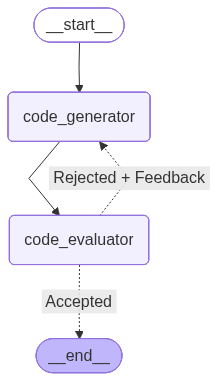

In [21]:
builder = StateGraph(State)

builder.add_node("code_generator", code_generator)
builder.add_node("code_evaluator", code_evaluator)

builder.add_edge(START, "code_generator")
builder.add_edge("code_generator", "code_evaluator")

builder.add_conditional_edges("code_evaluator",route_code,
                              {"Accepted": END,"Rejected + Feedback": "code_generator"})

graph = builder.compile()
graph

In [22]:
for data in graph.stream({'instruction':'자연수보다 작은 소수 개수 구하기'}, stream_mode='updates'):
    if 'code_generator' in data:
        print(data['code_generator']['code'])
    else:
        print(data['code_evaluator']['optimized'],'-->', data['code_evaluator']['feedback'])
    print('--------------')

```python
def count_primes_less_than_n(n):
    if n <= 2:
        return 0

    is_prime = [True] * n
    is_prime[0] = False
    is_prime[1] = False

    for p in range(2, int(n**0.5) + 1):
        if is_prime[p]:
            for multiple in range(p * p, n, p):
                is_prime[multiple] = False

    count = 0
    for i in range(2, n):
        if is_prime[i]:
            count += 1
    return count
```
--------------
optimized --> 제공된 파이썬 코드는 자연수보다 작은 소수의 개수를 세는 문제에 대해 잘 최적화되어 있습니다. 소수를 찾는 효율적인 알고리즘인 에라토스테네스의 체를 구현하고 있습니다.

**코드 길이:** 에라토스테네스의 체 알고리즘의 표준적인 구현으로, 가독성을 해치지 않으면서 간결하게 작성되었습니다. 이 문제 해결을 위한 효율적인 알고리즘 중에서는 이보다 유의미하게 짧으면서도 성능을 유지하는 코드를 작성하기 어렵습니다.

**실행 속도:** 에라토스테네스의 체는 O(n log log n)의 시간 복잡도를 가지므로, n이 커질수록 매우 효율적으로 작동합니다. 이는 소수 개수를 세는 가장 빠른 방법 중 하나입니다.

**메모리 효율성:** O(n)의 공간 복잡도를 가지며, n개의 불리언(boolean) 값을 저장하는 리스트를 사용합니다. 이는 이 알고리즘의 본질적인 특성이며, 일반적으로 이 문제에 대해 허용 가능한 수준의 메모리 사용량입니다.
--------------


In [23]:
for data in graph.stream({'instruction':'자연수 소인수분해'}, stream_mode='updates'):
    if 'code_generator' in data:
        print(data['code_generator']['code'])
    else:
        print(data['code_evaluator']['optimized'],'-->', data['code_evaluator']['feedback'])
    print('--------------')

```python
def prime_factorization(n):
    factors = {}
    d = 2
    temp_n = n

    if temp_n <= 1:
        return factors

    # Factor out 2s
    while temp_n % d == 0:
        factors[d] = factors.get(d, 0) + 1
        temp_n //= d

    # Factor out odd numbers
    d = 3
    while d * d <= temp_n:
        while temp_n % d == 0:
            factors[d] = factors.get(d, 0) + 1
            temp_n //= d
        d += 2

    # If temp_n is still greater than 1, it's a prime factor itself
    if temp_n > 1:
        factors[temp_n] = factors.get(temp_n, 0) + 1

    return factors
```
--------------
optimized --> 제공된 `prime_factorization` 코드는 소인수분해를 위한 일반적인 최적화 기법(예: 2를 먼저 처리하고 홀수만 확인하며, `d * d <= temp_n` 조건으로 반복 횟수를 줄이는 등)을 잘 적용하고 있습니다. 코드의 길이, 실행 속도, 메모리 효율성 측면에서 이미 잘 최적화되어 있습니다.
--------------


In [24]:
for data in graph.stream({'instruction':'Convex Hull 문제'}, stream_mode='updates'):
    if 'code_generator' in data:
        print(data['code_generator']['code'])
    else:
        print(data['code_evaluator']['optimized'],'-->', data['code_evaluator']['feedback'])
    print('--------------')

```python
def solve_convex_hull(points):
    """
    Computes the convex hull of a set of 2D points using the Monotone Chain algorithm.

    Args:
        points: A list of tuples, where each tuple (x, y) represents a 2D point.

    Returns:
        A list of tuples representing the points on the convex hull,
        ordered counter-clockwise.
    """
    n = len(points)
    if n <= 2:
        return sorted(list(set(points))) # Handle duplicates and ensure sorted for consistency

    # Sort points lexicographically (by x-coordinate, then by y-coordinate)
    points = sorted(list(set(points))) # Remove duplicates and sort

    # Helper function to determine turn direction (cross product)
    # > 0 for counter-clockwise (left turn)
    # < 0 for clockwise (right turn)
    # = 0 for collinear
    def cross_product(p1, p2, p3):
        return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])

    upper_hull = []
    # Build upper hull
    for p in points:
        while 